In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastDate

('2017-08-23')

In [11]:
yearData = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23')

In [12]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
measurement_df = pd.DataFrame(yearData)
measurement_df

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


In [13]:
measurement_df.sort_values("date", ascending = False)
measurement_df.date = pd.to_datetime(measurement_df.date)
measurement_df.dtypes

date    datetime64[ns]
prcp           float64
dtype: object

In [14]:
#measurement_df = measurement_df.set_index("date")
measurement_df = measurement_df.groupby("date")
measurement_df = measurement_df.sum()
measurement_df

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


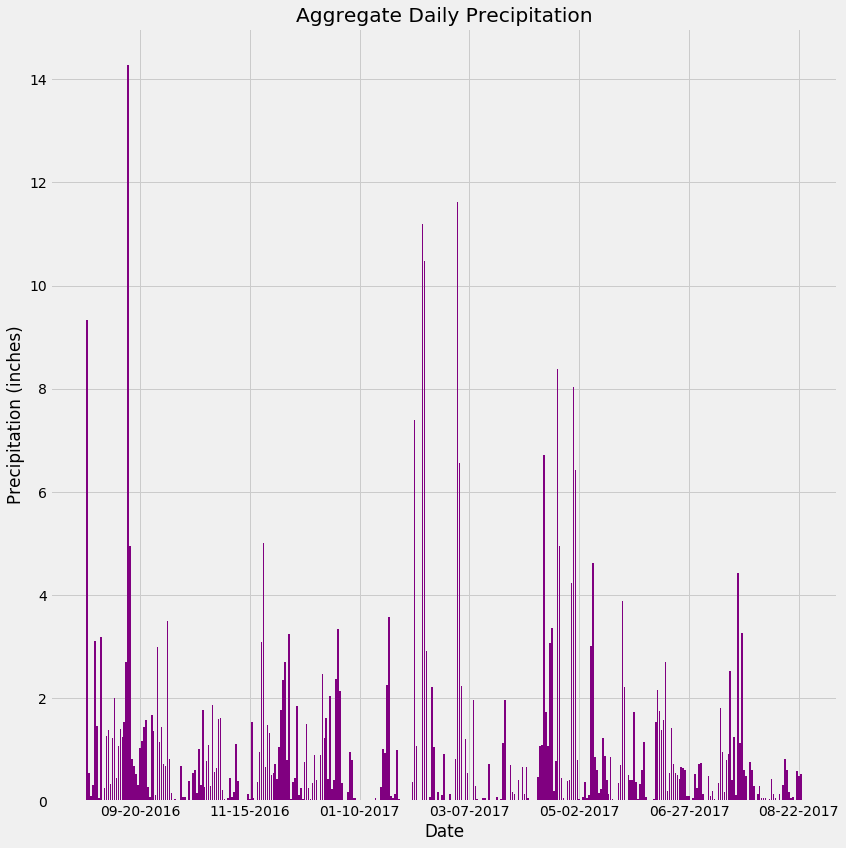

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(measurement_df.index.values,
       measurement_df['prcp'],
       color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Aggregate Daily Precipitation")

date_form = DateFormatter("%m-%d-%Y")
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=8))
plt.tight_layout() 
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStn = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activeStn

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
activeStn1 = activeStn[0][0]
activeStn1

sel = [Measurement.station, 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

stn1Data = session.query(*sel).filter(Measurement.station == activeStn1).all()
minT = stn1Data[0][2]
maxT = stn1Data[0][1]
avgT = stn1Data[0][3]

print(f"Station {activeStn1} -- Max Temp: {maxT}, Min Temp: {minT}, Avg Temp: {avgT}")

Station USC00519281 -- Max Temp: 85.0, Min Temp: 54.0, Avg Temp: 71.66378066378067


Text(0, 0.5, 'Frequency')

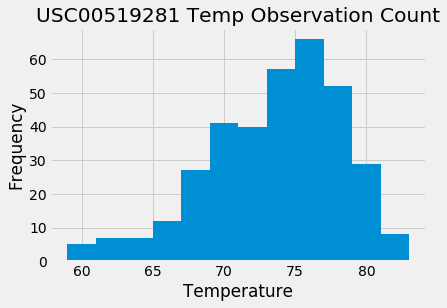

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearData2 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > '2016-08-23').filter(Measurement.station == activeStn1).all()
yearData2_df = pd.DataFrame(yearData2)

plt.hist(yearData2_df["tobs"], bins=12)
plt.title("USC00519281 Temp Observation Count")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

###Rob's Trip Dates: 2016-08-10 to 2016-08-19
robsTripTemps = calc_temps('2015-08-10', '2015-08-19')

minT2 = robsTripTemps[0][0]
maxT2 = robsTripTemps[0][2]
avgT2 = robsTripTemps[0][1]
yError = maxT2 - minT2
robsTripTemps


[(73.0, 78.1304347826087, 83.0)]

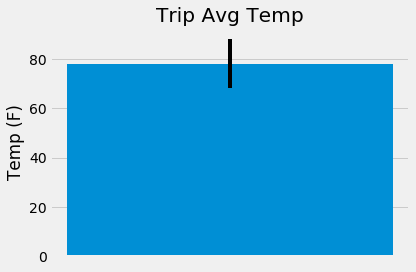

In [49]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = 100
#plt.bar(x_pos, avgT2, yerr=yError, align='center', alpha=0.5, ecolor='black', capsize=10)
#plt.set_title('Trip Avg Temp')
plt.bar(x_pos, avgT2, yerr=yError)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.tight_layout()

In [62]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
from pprint import pprint as pp
vacaRnfl = session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= '2015-08-10').\
            filter(Measurement.date <= '2015-08-19').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
pp(vacaRnfl)

[('USC00516128',
  0.41,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  0.04,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  0.01,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.01, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 0.01, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830',
  None,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00511918',
  None,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9)]


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [91]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
from datetime import datetime
# Set the start and end date of the trip
trpStart = '2015-08-10'
trpEnd = '2015-08-19'

# Use the start and end date to create a range of dates
dateRange = pd.date_range(trpStart,trpEnd,freq='d')

dateList = []
# Stip off the year and save a list of %m-%d strings
for date in dateRange:
    newDate = date.strftime('%m-%d')
    dateList.append(newDate)
dateList
# Loop through the list of %m-%d strings and calculate the normals for each date
normMin = []
normAvg = []
normMax = []
for date in dateList:
    dayNorm = daily_normals(date)
    normMin.append(dayNorm[0][0])
    normAvg.append(dayNorm[0][1])
    normMax.append(dayNorm[0][2])
norm_df = {"Date": dateList, "TMin": normMin, "TAvg": normAvg, "TMax": normMax}

In [92]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df = pd.DataFrame(norm_df)
norm_df = norm_df.set_index("Date")
norm_df

,TMin,TAvg,TMax
Date,,,
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0


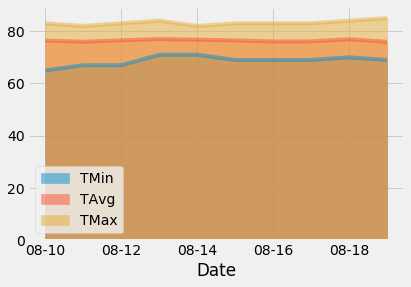

In [93]:
# Plot the daily normals as an area plot with `stacked=False`
norm_df.plot.area(stacked=False)
